# Reliability anaysis


## Packages and Helpers

In [25]:
# packages
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
from utils import load_dataframes
from scipy.stats import pearsonr
import random
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm
import pingouin as pg
import seaborn as sns

## Read Processed Data

In [26]:
# load overall df
all_data = pd.read_csv("processed_data/no_change_item_data.csv")

In [27]:
all_data.describe()

,score,score_top_n,H_score,score_expected
count,21192.000000,21192.000000,368.000000,304.000000
mean,4.384152,3.639868,0.399521,0.497405
std,8.750355,7.374620,0.114482,0.181776
min,0.000085,0.000000,0.169929,0.182070
25%,0.896453,0.919973,0.303420,0.331352
50%,1.613395,1.009995,0.395055,0.514704
75%,2.962514,3.022996,0.491583,0.646394
max,86.832153,91.283178,0.726647,0.794977


## Normalize item scores where tasks have different scales on different items
- AUDIT, FTND, GABS, PG

In [28]:
def normalize_per_scale(data):
    scales_to_normalize = ["AUDIT scale", "FTND scale", "GABS scale", "PG scale"]

    data = data.copy()

    # Loop over each experiment you want to normalize
    for scale in scales_to_normalize:
        mask = data["experiment"] == scale

        if mask.sum() == 0:
            continue  # skip if scale not present

        # Normalize score
        data.loc[mask, "score"] = (
            data.loc[mask, "score"] - data.loc[mask, "score"].min()
        ) / (data.loc[mask, "score"].max() - data.loc[mask, "score"].min())

        # Normalize score_top_n
        data.loc[mask, "score_top_n"] = (
            data.loc[mask, "score_top_n"] - data.loc[mask, "score_top_n"].min()
        ) / (data.loc[mask, "score_top_n"].max() - data.loc[mask, "score_top_n"].min())

    return data

all_data = normalize_per_scale(all_data)


In [29]:
# task_names = all_data['experiment'].unique()
# model_names = all_data["model"].unique()
# for model_name in model_names:
#     #for task_name in task_names:
#     sub_df = all_data[
#         (all_data['model'] == model_name) &
#         (all_data['experiment'] == "DFD task")
#     ]
#     print(sub_df)

## Chronbach's Alpha

In [30]:
# function:
def compute_cronbach_alpha(score = "score"):
    results = []

    # loop through experiments
    for exp, exp_data in all_data.groupby("experiment"):
        
        # check whether this experiment has subcategories
        if exp_data["category"].notna().any() and exp != "SOEP scale":
            # compute alpha per category (domain)
            for domain, domain_data in exp_data.groupby("category"):
                df_wide = domain_data.pivot_table(
                    index="model", columns="item", values=score
                )
                #print(df_wide)
                if df_wide.shape[1] > 1:
                    alpha, ci = pg.cronbach_alpha(df_wide)
                else:
                    alpha, ci = None, (None, None)
                
                results.append({
                    "experiment": exp,
                    "domain": domain,
                    "alpha": alpha,
                    "alpha_CI": ci
                })
        else:
            # compute alpha for the whole experiment
            df_wide = exp_data.pivot_table(
                index="model", columns="item", values=score
            )
            #print(exp, df_wide.std().describe())
            if df_wide.shape[1] > 1:
                alpha, ci = pg.cronbach_alpha(df_wide)
            else:
                alpha, ci = None, (None, None)
            
            results.append({
                "experiment": exp,
                "domain": "total",  # no subdomain
                "alpha": alpha,
                "alpha_CI": ci
            })

    # convert to DataFrame
    return(pd.DataFrame(results))



In [31]:
# ---- Cronbach's alpha per domain or directly per scale, depending on whether the scale has subdomains ----
alpha_df = compute_cronbach_alpha()


# ---- Cronbach's alpha per domain or directly per scale, depending on whether the scale has subdomains ----
alpha_top_n_df = compute_cronbach_alpha(score = "score_top_n")


# Merge only selected columns
alpha_df = alpha_df.merge(
    alpha_top_n_df,
    on=["experiment", "domain"],
    how="inner",
    suffixes=("_total", "_top_n")
)

display(alpha_df)

,experiment,domain,alpha_total,alpha_CI_total,alpha_top_n,alpha_CI_top_n
0,AUDIT scale,total,0.934789,"[0.903, 0.96]",0.889584,"[0.836, 0.931]"
1,BARRAT scale,BISa,0.973389,"[0.96, 0.984]",0.952786,"[0.929, 0.971]"
2,BARRAT scale,BISm,0.965052,"[0.948, 0.978]",0.950272,"[0.926, 0.969]"
3,BARRAT scale,BISn,0.975071,"[0.963, 0.985]",0.960456,"[0.941, 0.975]"
4,BART task,total,0.984716,"[0.977, 0.991]",0.984364,"[0.977, 0.99]"
5,CARE scale,CAREa,0.856412,"[0.785, 0.911]",0.892074,"[0.838, 0.933]"
6,CARE scale,CAREs,0.651253,"[0.468, 0.787]",0.688656,"[0.525, 0.81]"
7,CARE scale,CAREw,0.961134,"[0.939, 0.977]",0.938256,"[0.903, 0.963]"
8,CCT task,total,0.984565,"[0.977, 0.991]",0.978183,"[0.967, 0.987]"
9,DAST scale,total,0.975666,"[0.964, 0.985]",0.957921,"[0.938, 0.974]"


In [37]:
df_wide = all_data[all_data["experiment"] == "SSSV scale"].pivot_table(index='model', columns='item', values='score')

# Compute correlation between models
correlations = df_wide.corr()
correlations

item,1,10,11,12,13,14,15,16,17,18,...,37,38,39,4,40,5,6,7,8,9
item,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.058680,0.144959,0.114134,0.096880,0.134064,0.105660,0.111031,0.175850,0.151256,...,0.073915,0.089432,0.078777,0.291211,0.178988,0.274566,0.265542,0.191129,0.157316,0.148512
10,0.058680,1.000000,0.919444,0.893430,0.911418,0.897201,0.905530,0.901979,0.907209,0.925989,...,0.829452,0.871262,0.862239,0.843319,0.855259,0.807579,0.856665,0.906381,0.912355,0.891214
11,0.144959,0.919444,1.000000,0.945507,0.957675,0.913542,0.918461,0.921395,0.888452,0.949730,...,0.878284,0.915741,0.898280,0.854700,0.869689,0.845916,0.849450,0.842021,0.899266,0.918607
12,0.114134,0.893430,0.945507,1.000000,0.935493,0.941687,0.941101,0.931807,0.919847,0.942667,...,0.905271,0.898949,0.892608,0.859100,0.860276,0.870767,0.852839,0.856015,0.926907,0.900988
13,0.096880,0.911418,0.957675,0.935493,1.000000,0.920377,0.953114,0.934843,0.917647,0.938653,...,0.873730,0.905393,0.890764,0.800584,0.875543,0.837609,0.846896,0.850076,0.896243,0.916010
14,0.134064,0.897201,0.913542,0.941687,0.920377,1.000000,0.959107,0.969204,0.942558,0.948519,...,0.904039,0.911967,0.883912,0.853009,0.885053,0.862709,0.885670,0.872333,0.940646,0.927637
15,0.105660,0.905530,0.918461,0.941101,0.953114,0.959107,1.000000,0.957642,0.956611,0.955845,...,0.891025,0.913374,0.897189,0.832591,0.887388,0.873741,0.879123,0.876948,0.927809,0.918455
16,0.111031,0.901979,0.921395,0.931807,0.934843,0.969204,0.957642,1.000000,0.951411,0.959338,...,0.904351,0.920992,0.912218,0.802884,0.893678,0.836691,0.885316,0.854780,0.916036,0.940367
17,0.175850,0.907209,0.888452,0.919847,0.917647,0.942558,0.956611,0.951411,1.000000,0.945737,...,0.864513,0.881976,0.882912,0.828012,0.895245,0.869362,0.918007,0.898059,0.939581,0.901482


## Split-half Reliability

In [33]:
def split_half_reliability(df_items, n_splits=100):
    """Compute average split-half reliability (Spearman-Brown corrected)."""

    k = df_items.shape[1]
    
    if k < 2:
        return None, None

    cols = df_items.columns
    results = []

    for _ in range(n_splits):
        shuffled = np.random.permutation(cols)
        half1 = shuffled[:k//2]
        half2 = shuffled[k//2:]

        s1 = df_items[half1].sum(axis=1)
        s2 = df_items[half2].sum(axis=1)

        r, _ = pearsonr(s1, s2)

        if np.isfinite(r):
            r_sb = (2 * r) / (1 + r)  # Spearman-Brown correction
            results.append(r_sb)

    if len(results) == 0:
        return None, None
    
    return np.mean(results), np.std(results)


In [34]:
def compute_split_half_reliability(score="score"):
    rows = []  # final list of results

    for exp, exp_data in all_data.groupby("experiment"):

        # case 1: experiments with domains
        if exp_data["category"].notna().any() and exp != "SOEP scale":
            for domain, domain_data in exp_data.groupby("category"):

                df_wide = domain_data.pivot_table(
                    index="model", columns="item", values=score
                )

                mean_rsb, sd_rsb = split_half_reliability(df_wide)

                rows.append({
                    "experiment": exp,
                    "domain": domain,
                    "split_half_mean": mean_rsb,
                    "split_half_sd": sd_rsb
                })

        # case 2: experiments without domains
        else:
            df_wide = exp_data.pivot_table(
                index="model", columns="item", values=score
            )

            mean_rsb, sd_rsb = split_half_reliability(df_wide)

            rows.append({
                "experiment": exp,
                "domain": "total",
                "split_half_mean": mean_rsb,
                "split_half_sd": sd_rsb
            })

    return pd.DataFrame(rows)


In [35]:
split_half_reliability = compute_split_half_reliability()
split_half_reliability

,experiment,domain,split_half_mean,split_half_sd
0,AUDIT scale,total,0.958363,0.018661
1,BARRAT scale,BISa,0.977354,0.014251
2,BARRAT scale,BISm,0.973039,0.015036
3,BARRAT scale,BISn,0.979521,0.009250
4,BART task,total,0.987914,0.005431
5,CARE scale,CAREa,0.990054,0.009906
6,CARE scale,CAREs,0.976357,0.020573
7,CARE scale,CAREw,0.996112,0.000704
8,CCT task,total,0.994327,0.003173
9,DAST scale,total,0.977306,0.008637


## Visualize Distributions per model

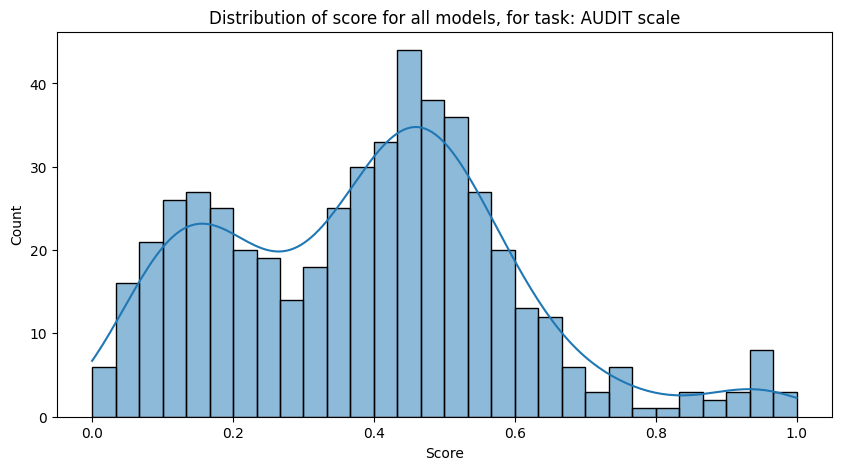

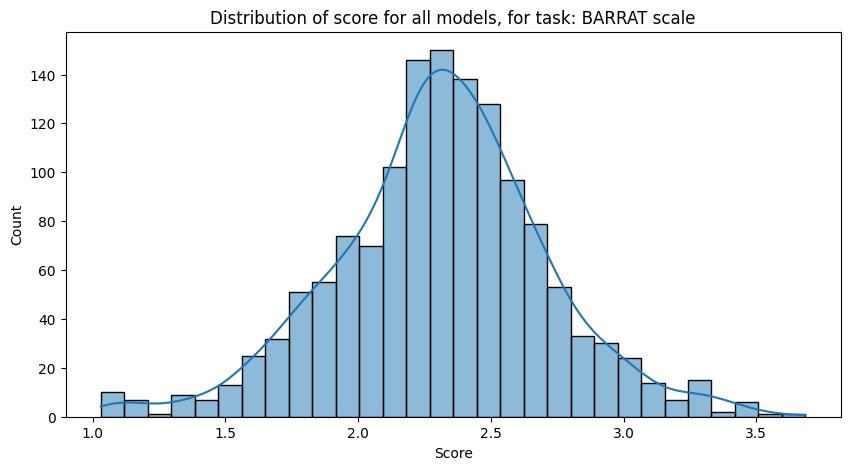

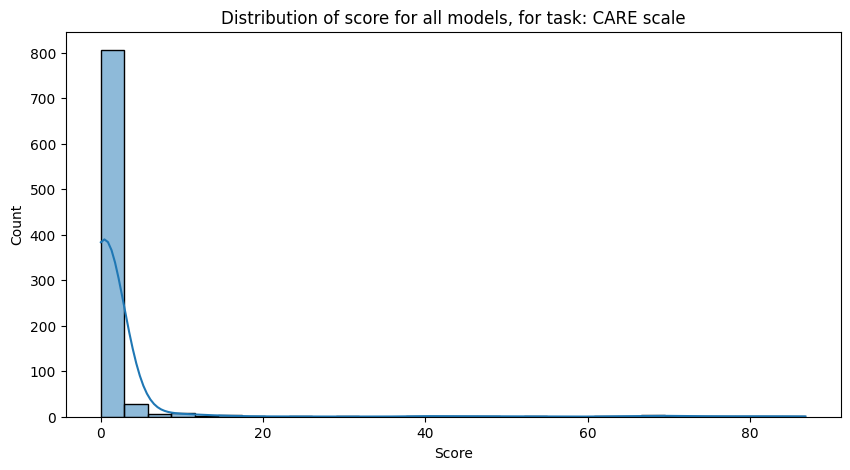

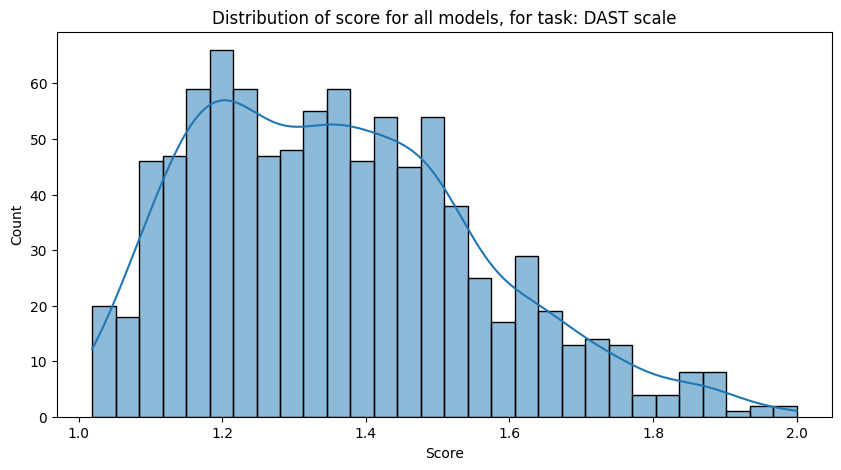

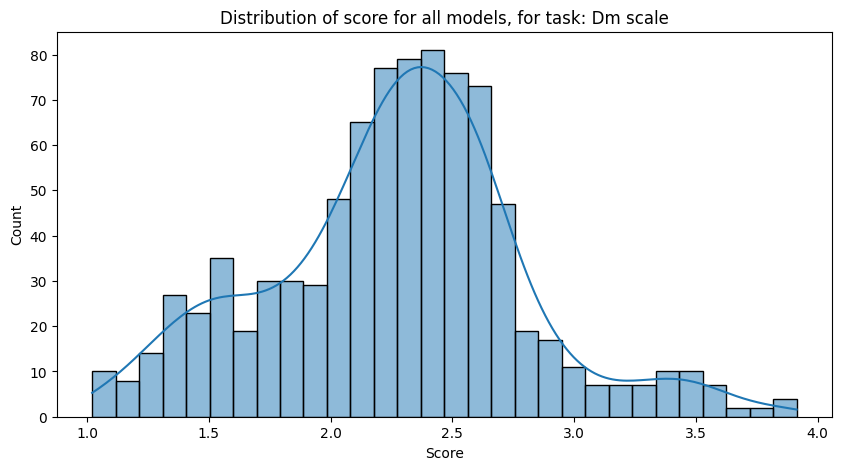

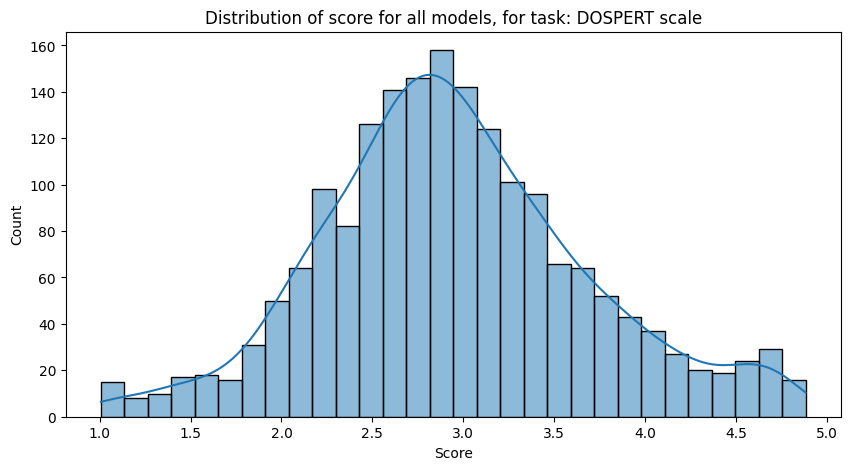

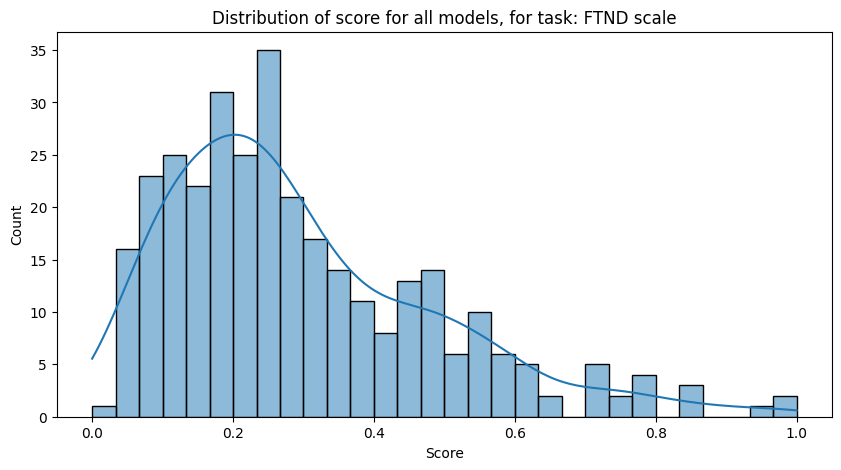

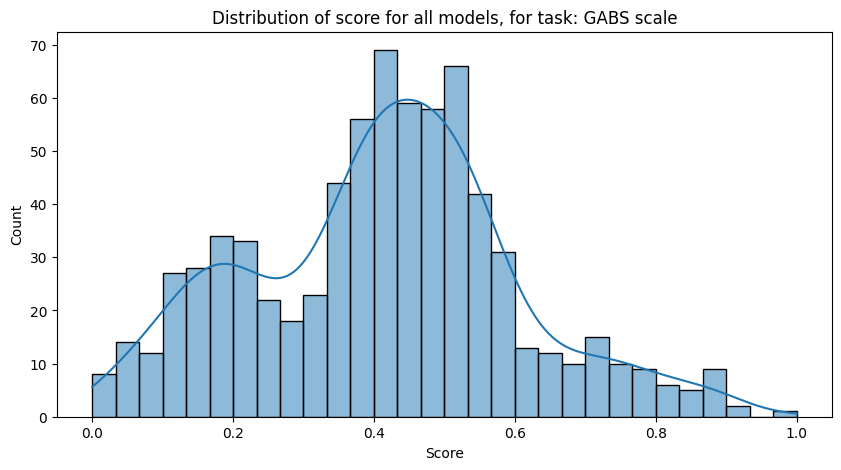

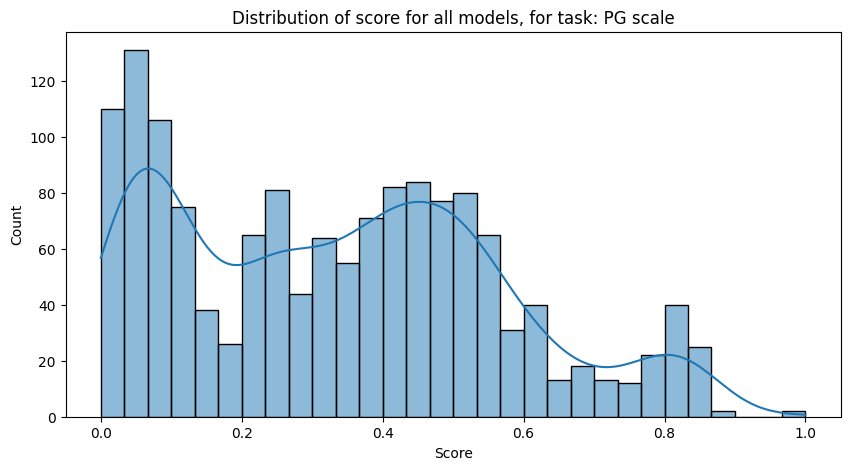

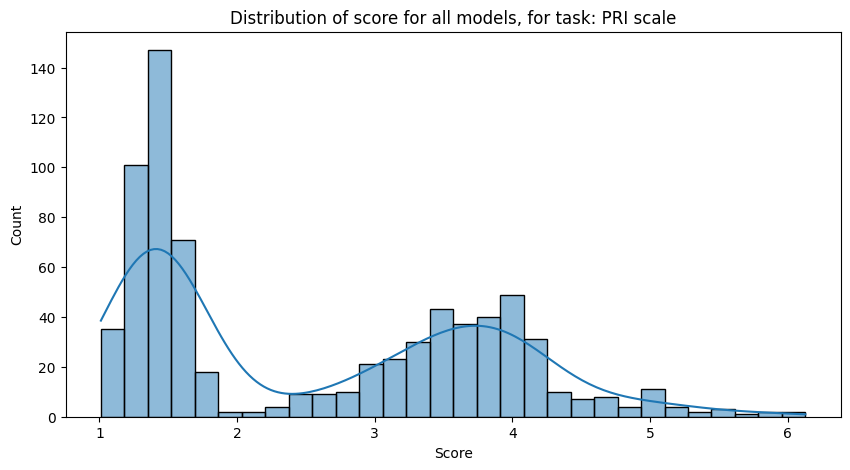

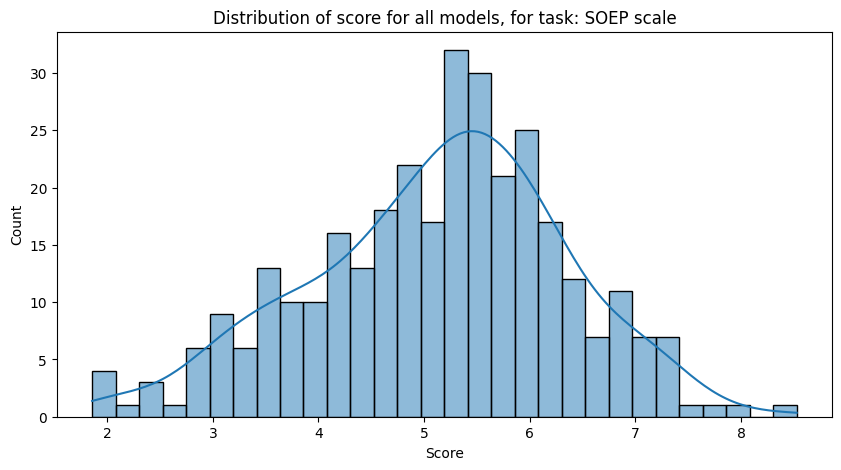

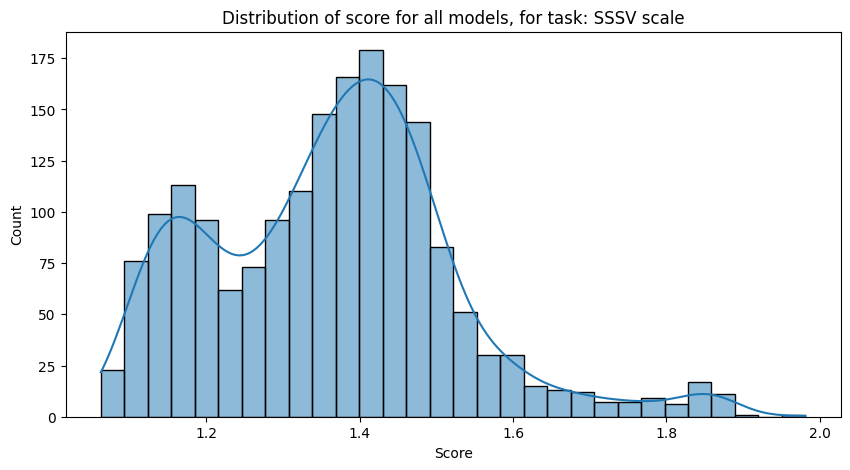

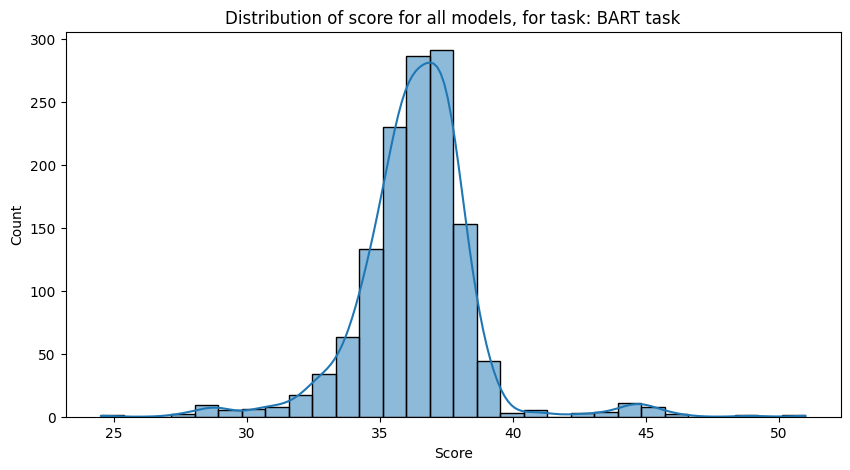

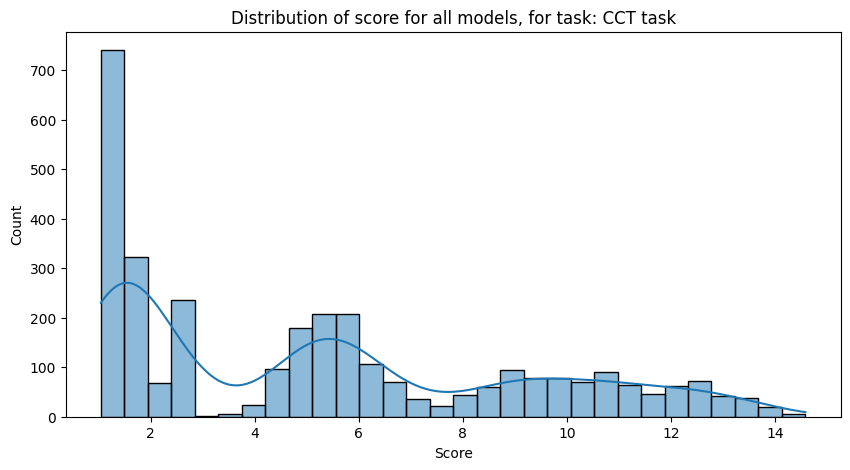

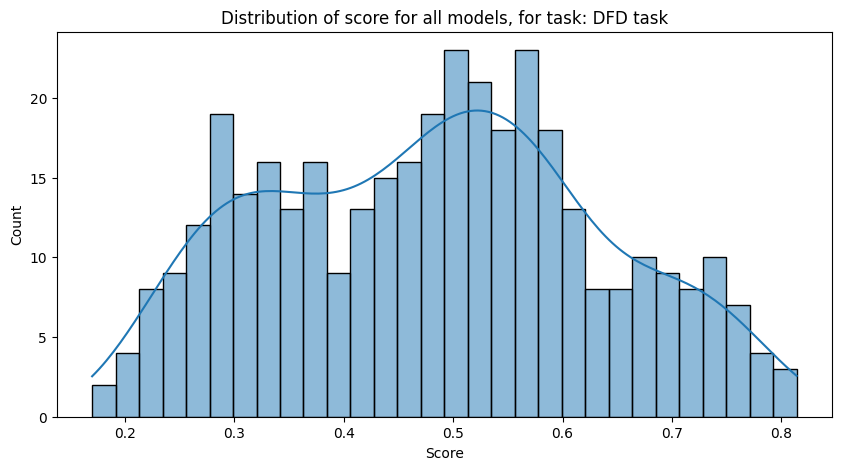

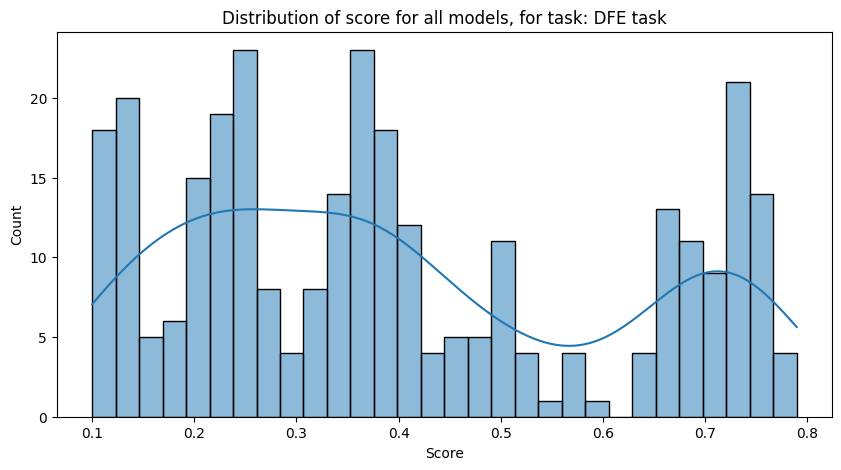

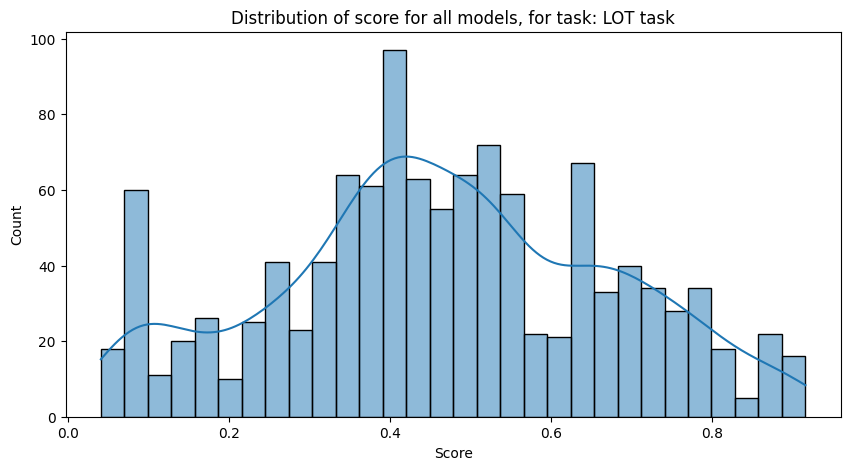

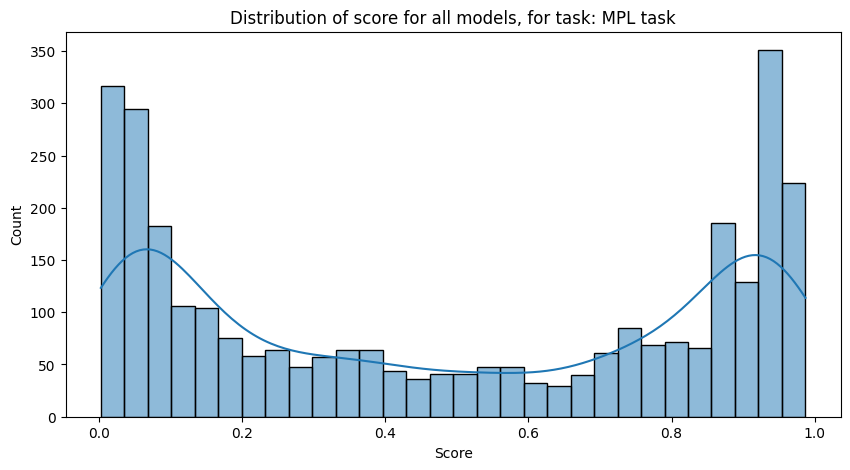

In [36]:
# Visualise distribution (focus on variance) per model of logprobs

#model_names = all_data['model'].unique()
task_names = all_data['experiment'].unique()

#for model_name in model_names:
for task_name in task_names:
    df_plot = all_data[
        #(all_data['model'] == model_name) &
        (all_data['experiment'] == task_name)
    ]
    
    plt.figure(figsize=(10, 5))
    sns.histplot(data=df_plot, x="score", kde=True, bins=30)  
    plt.title(f'Distribution of score for all models, for task: {task_name}')
    plt.xlabel('Score')
    plt.ylabel('Count')
    plt.show()